In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')

# Modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error

# Pruebas estadísticas
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf                # autocorrelación
from statsmodels.tsa.stattools import adfuller, kpss                        # estacionariedad
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch           # heterocedasticidad residuos
from scipy.stats import shapiro, anderson, jarque_bera                      # normalidad residuos

# Preparar base de datos

In [43]:
df_envigado_2018_2020 = pd.read_excel("Consumos 2018-2020.xlsx", sheet_name="METRO_ENV", header=15, usecols="B,AL", index_col=0)
df_envigado_2018_2020 = df_envigado_2018_2020[:-5]
df_san_diego_2018_2020 = pd.read_excel("Consumos 2018-2020.xlsx", sheet_name="METRO_SAND", header=15, usecols="B,AL", index_col=0)
df_san_diego_2018_2020 = df_san_diego_2018_2020[:-5]
df_zamora_2018_2020 = pd.read_excel("Consumos 2018-2020.xlsx", sheet_name="METRO_ZAMO", header=15, usecols="B,AL", index_col=0)
df_zamora_2018_2020 = df_zamora_2018_2020[:-5]

df_envigado_2021_2024 = pd.read_excel("Consumos de energía 2021-2022-2023- 2024.xlsx", sheet_name="Envigado", header=2, usecols="G:S", nrows=4, index_col=0)
df_san_diego_2021_2024 = pd.read_excel("Consumos de energía 2021-2022-2023- 2024.xlsx", sheet_name="San Diego", header=1, usecols="G:S", nrows=4, index_col=0)
df_zamora_2021_2024 = pd.read_excel("Consumos de energía 2021-2022-2023- 2024.xlsx", sheet_name="Zamora", header=1, usecols="G:S", nrows=4, index_col=0)

In [44]:
fechas = pd.date_range(start="2018-01-01", end="2020-12-31", freq="d")
df_envigado_2018_2020.index = fechas
df_envigado_2018_2020 = df_envigado_2018_2020.resample("ME").sum()
df_envigado_2018_2020.columns = ["Consumo kWh"]

df_san_diego_2018_2020.index = fechas
df_san_diego_2018_2020 = df_san_diego_2018_2020.resample("ME").sum()
df_san_diego_2018_2020.columns = ["Consumo kWh"]

df_zamora_2018_2020.index = fechas
df_zamora_2018_2020 = df_zamora_2018_2020.resample("ME").sum()
df_zamora_2018_2020.columns = ["Consumo kWh"]

fechas = pd.date_range(start="2021-01-01", end="2024-12-31", freq="M")

df_envigado_2021_2024 = df_envigado_2021_2024.stack().reset_index(drop=True).rename("Consumo kWh").to_frame()
df_envigado_2021_2024.index = fechas

df_san_diego_2021_2024 = df_san_diego_2021_2024.stack().reset_index(drop=True).rename("Consumo kWh").to_frame()
df_san_diego_2021_2024.index = fechas

df_zamora_2021_2024 = df_zamora_2021_2024.stack().reset_index(drop=True).rename("Consumo kWh").to_frame()
df_zamora_2021_2024.index = fechas

In [ ]:
df_envigado = pd.concat([df_envigado_2018_2020, df_envigado_2021_2024])
df_san_diego = pd.concat([df_san_diego_2018_2020, df_san_diego_2021_2024])
df_zamora = pd.concat([df_zamora_2018_2020, df_zamora_2021_2024])

df_lineaA = pd.concat([df_envigado, df_san_diego, df_zamora], axis=1)
df_lineaA.columns = ["Envigado", "San Diego", "Zamora"]
df_lineaA = np.log(df_lineaA)

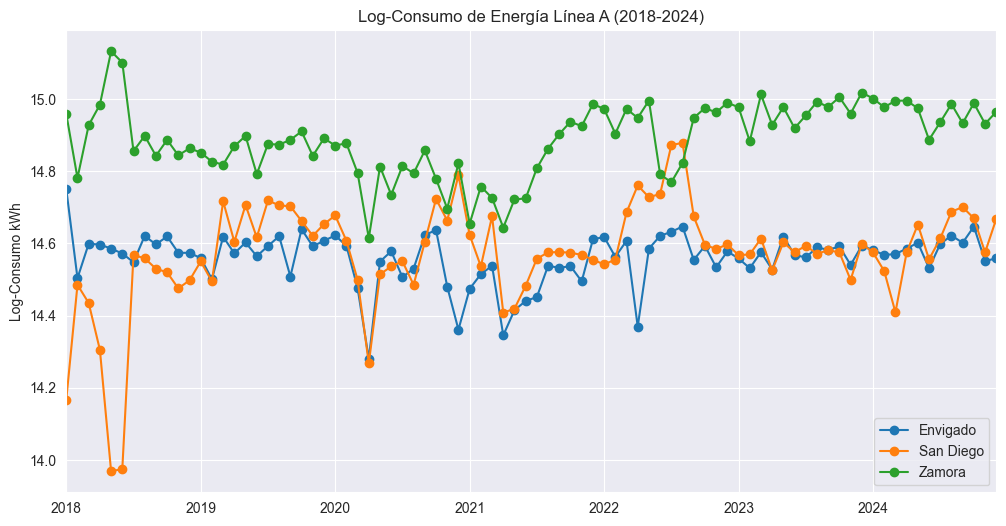

In [46]:
df_lineaA.plot(figsize=(12, 6), marker='o')
plt.title("Log-Consumo de Energía Línea A (2018-2024)")
plt.ylabel("Log-Consumo kWh")
plt.show()

In [50]:
df_lineaA.to_csv("LogConsumo_LineaA_2018-2024.csv")

# Leer base de datos y pruebas diagnosticas

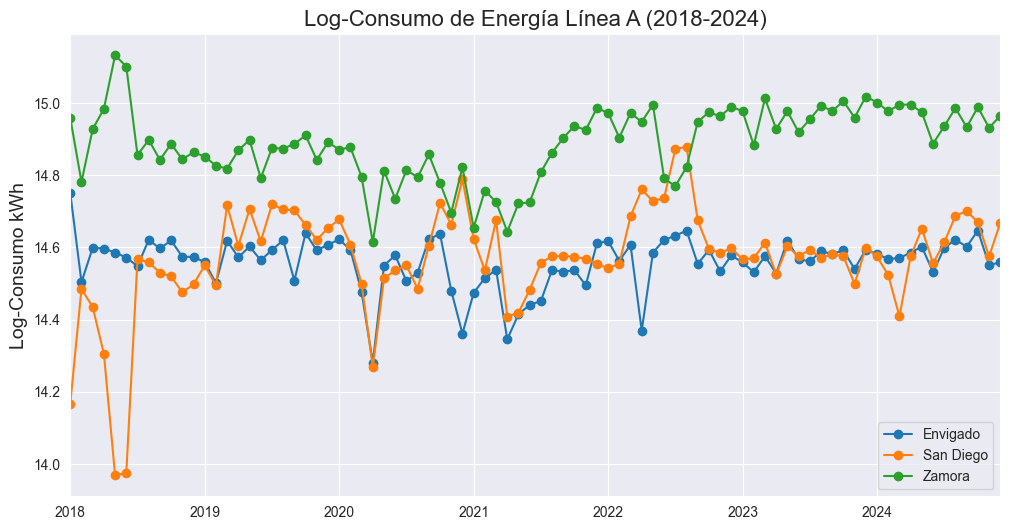

In [52]:
df_lineaA = pd.read_csv("LogConsumo_LineaA_2018-2024.csv", index_col=0, header=0, parse_dates=True)
df_lineaA.index.freq = "ME"
df_lineaA.plot(figsize=(12, 6), marker='o')
plt.title("Log-Consumo de Energía Línea A (2018-2024)", fontsize=16)
plt.ylabel("Log-Consumo kWh", fontsize=14)
plt.show()

In [53]:
df_lineaA.describe()

,Envigado,San Diego,Zamora
count,84.000000,84.000000,84.000000
mean,14.559528,14.571304,14.889813
std,0.071909,0.146979,0.100238
min,14.280313,13.968797,14.614470
25%,14.533269,14.528699,14.822384
50%,14.573862,14.575045,14.897676
75%,14.601687,14.662296,14.972855
max,14.750356,14.878410,15.132056


In [54]:
print("H0: non-stationary\n---------------------------------")
for col in df_lineaA.columns:
    result = adfuller(df_lineaA[col])
    print(f'ADF Statistic for {col}:', result[0])
    print(f'p-value for {col}:', result[1])
    print('Number of lags used:', result[2])
    if result[1] < 0.05:
        print(f'The series {col} is stationary.')
    else:
        print(f'The series {col} is non-stationary.')
    print('---')

H0: non-stationary
---------------------------------
ADF Statistic for Envigado: -2.1485055248739657
p-value for Envigado: 0.22546257702988098
Number of lags used: 7
The series Envigado is non-stationary.
---
ADF Statistic for San Diego: -4.740652997708908
p-value for San Diego: 7.053644699038816e-05
Number of lags used: 0
The series San Diego is stationary.
---
ADF Statistic for Zamora: -2.655539639202639
p-value for Zamora: 0.0820528521288672
Number of lags used: 1
The series Zamora is non-stationary.
---


In [55]:
print("H0: stationary\n---------------------------------")
for col in df_lineaA.columns:
    result = kpss(df_lineaA[col])
    print(f'ADF Statistic for {col}:', result[0])
    print(f'p-value for {col}:', result[1])
    print('Number of lags used:', result[2])
    if result[1] < 0.05:
        print(f'The series {col} is non-stationary.')
    else:
        print(f'The series {col} is stationary.')
    print('---')

H0: stationary
---------------------------------
ADF Statistic for Envigado: 0.25958039885250345
p-value for Envigado: 0.1
Number of lags used: 3
The series Envigado is stationary.
---
ADF Statistic for San Diego: 0.40609925924674467
p-value for San Diego: 0.07452618135916178
Number of lags used: 4
The series San Diego is stationary.
---
ADF Statistic for Zamora: 0.5004404637751726
p-value for Zamora: 0.04156746311369987
Number of lags used: 5
The series Zamora is non-stationary.
---


C:\Users\ANDRES\AppData\Local\Temp\ipykernel_28244\2938802323.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df_lineaA[col])


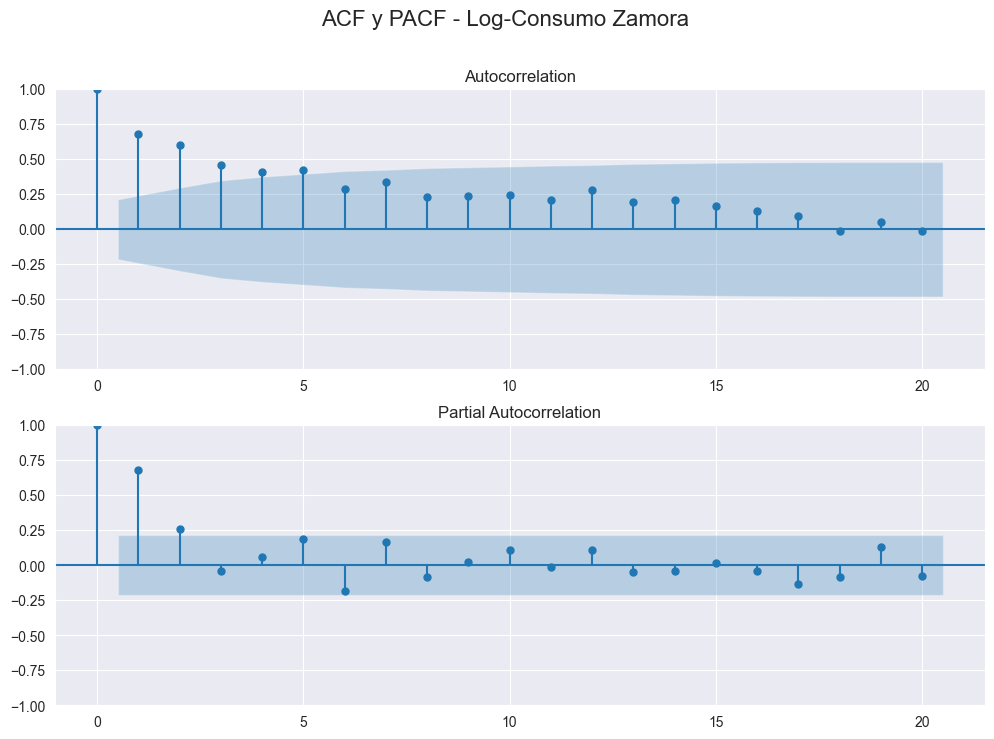

In [56]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_lineaA["Zamora"], ax=ax[0])
plot_pacf(df_lineaA["Zamora"], ax=ax[1])
plt.suptitle("ACF y PACF - Log-Consumo Zamora", fontsize=16)
plt.show()

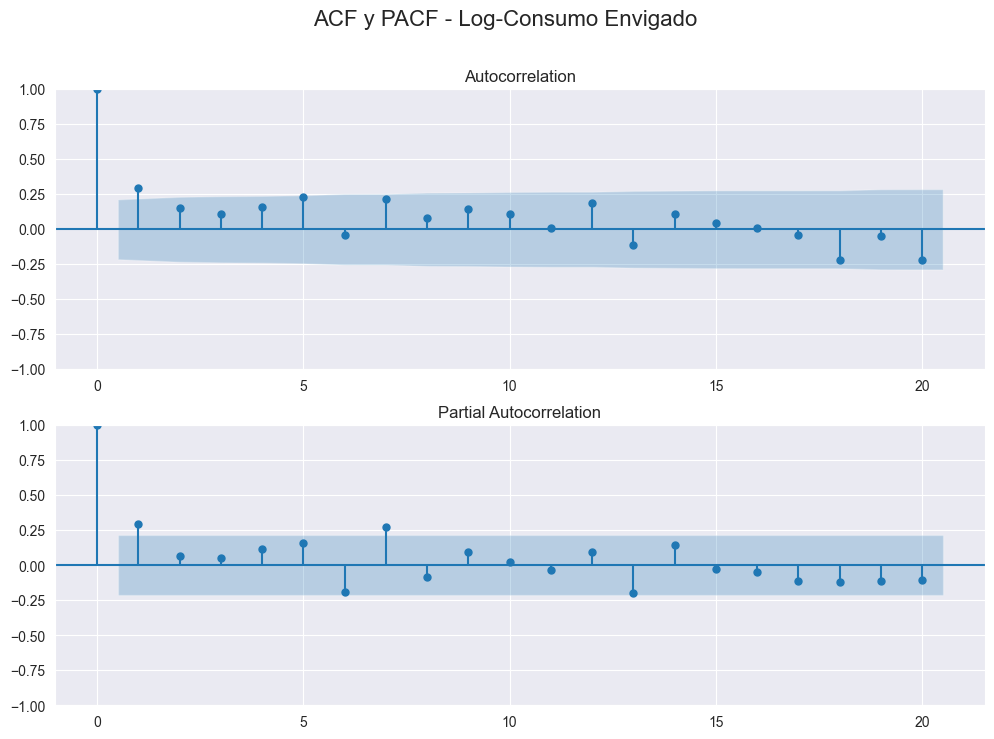

In [57]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_lineaA["Envigado"], ax=ax[0])
plot_pacf(df_lineaA["Envigado"], ax=ax[1])
plt.suptitle("ACF y PACF - Log-Consumo Envigado", fontsize=16)
plt.show()

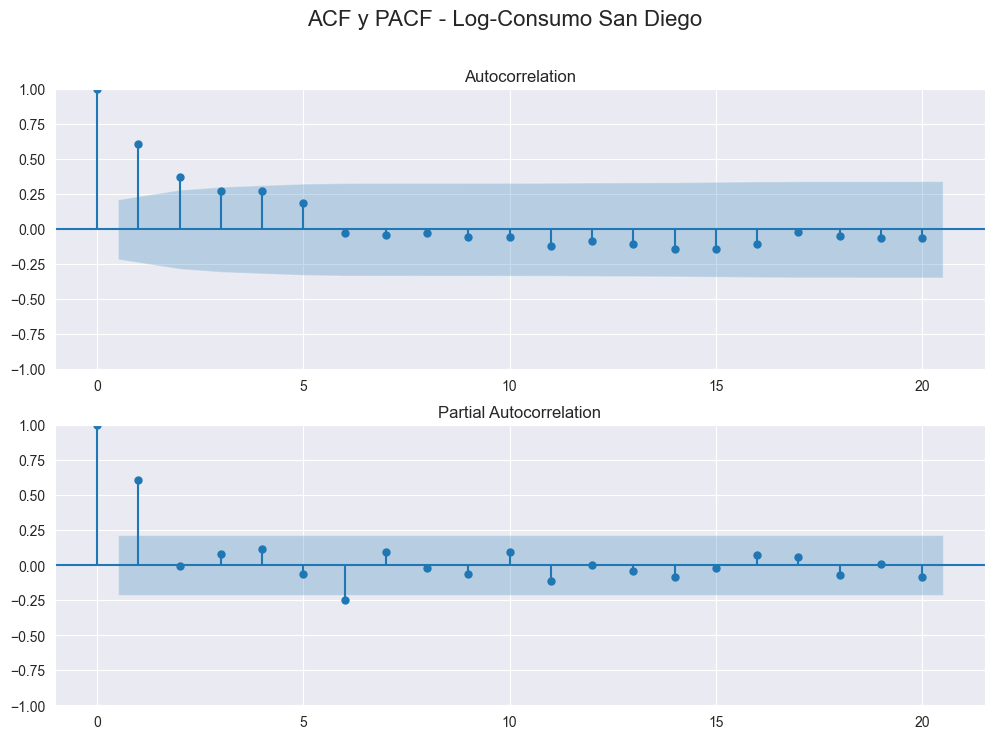

In [58]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_lineaA["San Diego"], ax=ax[0])
plot_pacf(df_lineaA["San Diego"], ax=ax[1])
plt.suptitle("ACF y PACF - Log-Consumo San Diego", fontsize=16)
plt.show()

# Modelación Zamora

## Modelo AR(1)

In [59]:
model_zamora_ar1=ARIMA(df_lineaA["Zamora"], order=(1,0,0)) # p, d, q
results_zamora_ar1=model_zamora_ar1.fit()
results_zamora_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Zamora   No. Observations:                   84
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 101.032
Date:                Wed, 03 Dec 2025   AIC                           -196.064
Time:                        22:21:18   BIC                           -188.771
Sample:                    01-31-2018   HQIC                          -193.132
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8933      0.028    532.881      0.000      14.839      14.948
ar.L1          0.6832      0.071      9.682      0.000       0.545       0.821
sigma2         0.0052      0.001      6.776      0.000       0.004       0.007
===================================================================================
Ljung-Box (L1) (Q):                   2.41   Jarque-Bera (JB):                10.14
Prob(Q):                              0.12   Prob(JB):                         0.01
Heteroskedasticity (H):               0.41   Skew:                            -0.76
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

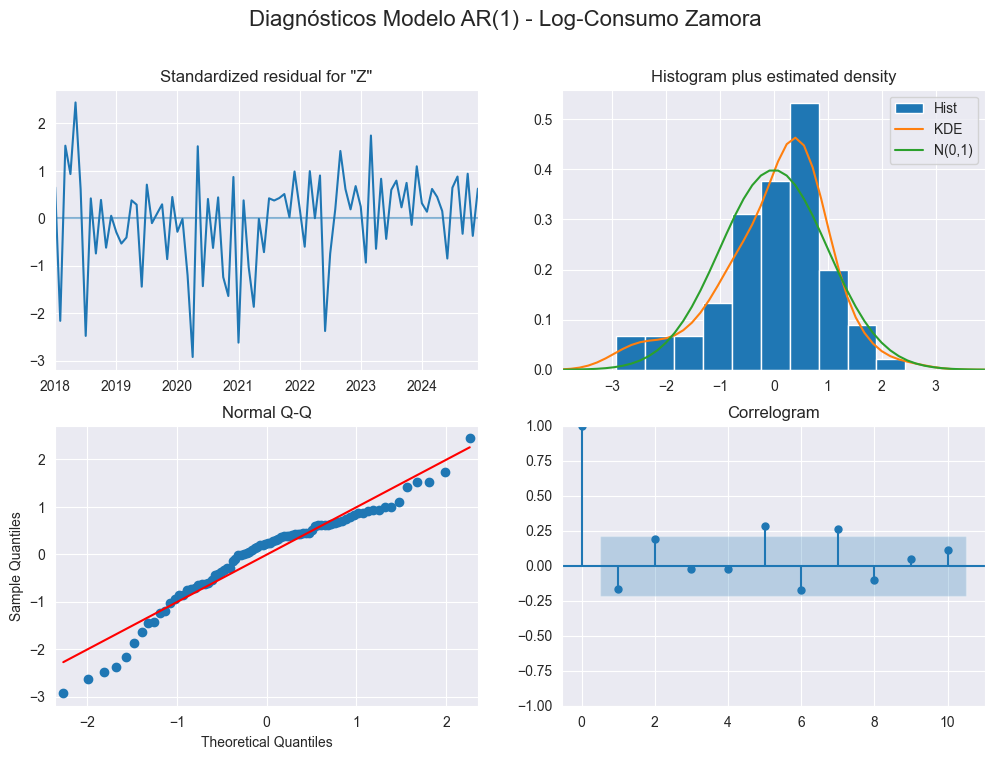

In [60]:
results_zamora_ar1.plot_diagnostics(figsize=(12,8))
plt.suptitle("Diagnósticos Modelo AR(1) - Log-Consumo Zamora", fontsize=16)
plt.show()

No se cumple normalidad de residuos

In [61]:
predicciones_zamora_ar1 = results_zamora_ar1.get_prediction(start=0, end=len(df_lineaA)-1)
yhat_zamora_ar1 = predicciones_zamora_ar1.predicted_mean
yhat_zamora_ar1_conf_int = predicciones_zamora_ar1.conf_int(alpha=0.05)

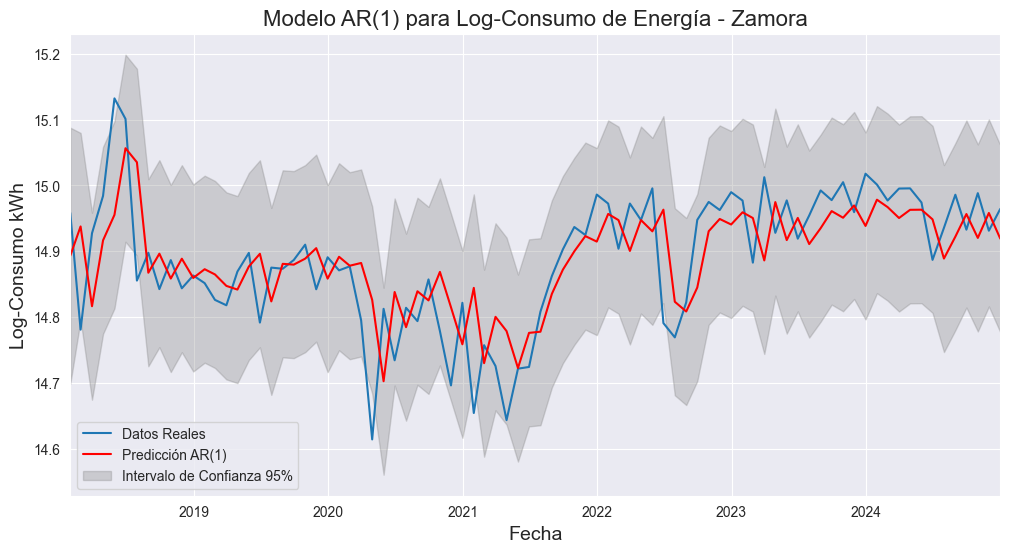

In [62]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_lineaA.index, y=df_lineaA["Zamora"], label="Datos Reales")
sns.lineplot(x=df_lineaA.index, y=yhat_zamora_ar1, color='red', label="Predicción AR(1)")
plt.fill_between(df_lineaA.index, yhat_zamora_ar1_conf_int.iloc[:,0], yhat_zamora_ar1_conf_int.iloc[:,1], color='gray', alpha=0.3, label="Intervalo de Confianza 95%")
plt.xlim(df_lineaA.index[0], df_lineaA.index[-1])
plt.ylabel("Log-Consumo kWh", fontsize=14)
plt.xlabel("Fecha", fontsize=14)
plt.legend()
plt.title("Modelo AR(1) para Log-Consumo de Energía - Zamora", fontsize=16)
plt.show()

In [63]:
# Métricas de evaluación
mape_ar1 = mean_absolute_percentage_error(df_lineaA["Zamora"], yhat_zamora_ar1)*100
print(f"MSE AR(1): {results_zamora_ar1.mse:.3f}")
print(f"MAPE AR(1): {mape_ar1:.3f}%")
print(f"MAE AR(1): {results_zamora_ar1.mae:.3f}")

MSE AR(1): 0.005
MAPE AR(1): 0.376%
MAE AR(1): 0.056


In [19]:
# Destransformar de log a nivel
# sigma2 = results_ar1.params[2]   # varianza del error
# pred_levels_unbiased = np.exp(prediccion_ar1 + 0.5 * sigma2)

## Modelo MA(1)

In [64]:
model_zamora_ma1=ARIMA(df_lineaA["Zamora"], order=(0,0,1)) # p, d, q
results_zamora_ma1=model_zamora_ma1.fit()
results_zamora_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Zamora   No. Observations:                   84
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  89.255
Date:                Wed, 03 Dec 2025   AIC                           -172.510
Time:                        22:22:45   BIC                           -165.218
Sample:                    01-31-2018   HQIC                          -169.579
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8910      0.015   1011.429      0.000      14.862      14.920
ma.L1          0.4896      0.095      5.162      0.000       0.304       0.676
sigma2         0.0070      0.001      6.585      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   3.05   Jarque-Bera (JB):                 5.64
Prob(Q):                              0.08   Prob(JB):                         0.06
Heteroskedasticity (H):               0.64   Skew:                            -0.60
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

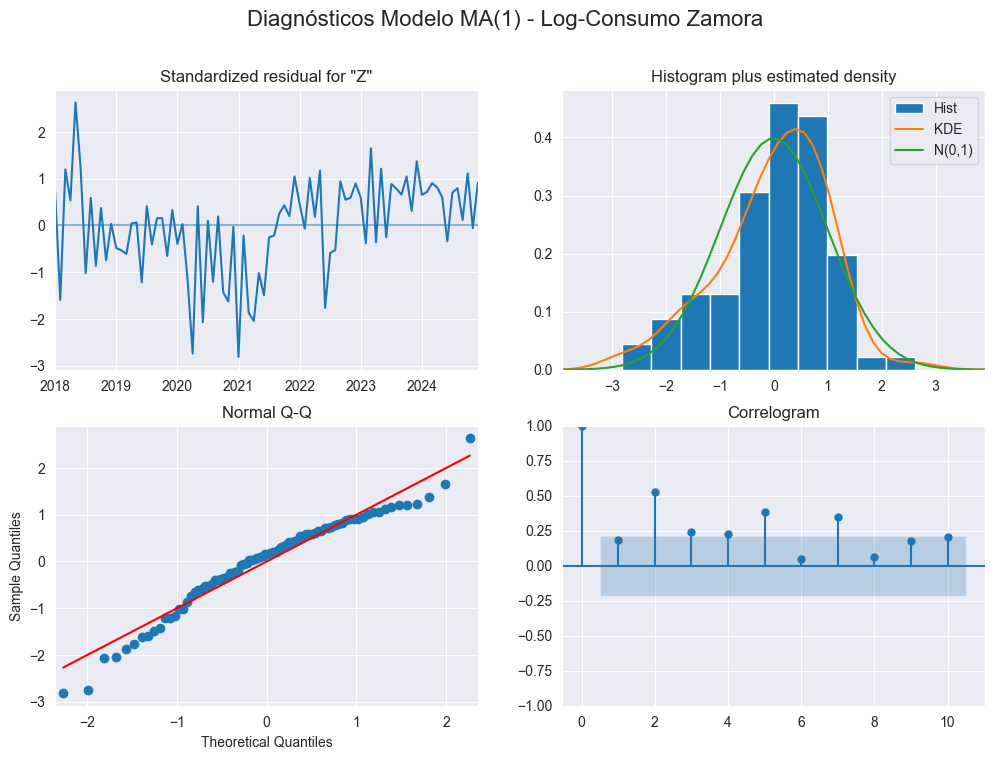

In [65]:
results_zamora_ma1.plot_diagnostics(figsize=(12,8))
plt.suptitle("Diagnósticos Modelo MA(1) - Log-Consumo Zamora", fontsize=16)
plt.show()

In [66]:
predicciones_zamora_ma1 = results_zamora_ma1.get_prediction(start=0, end=len(df_lineaA)-1)
yhat_zamora_ma1 = predicciones_zamora_ma1.predicted_mean
yhat_zamora_ma1_conf_int = predicciones_zamora_ma1.conf_int(alpha=0.05)

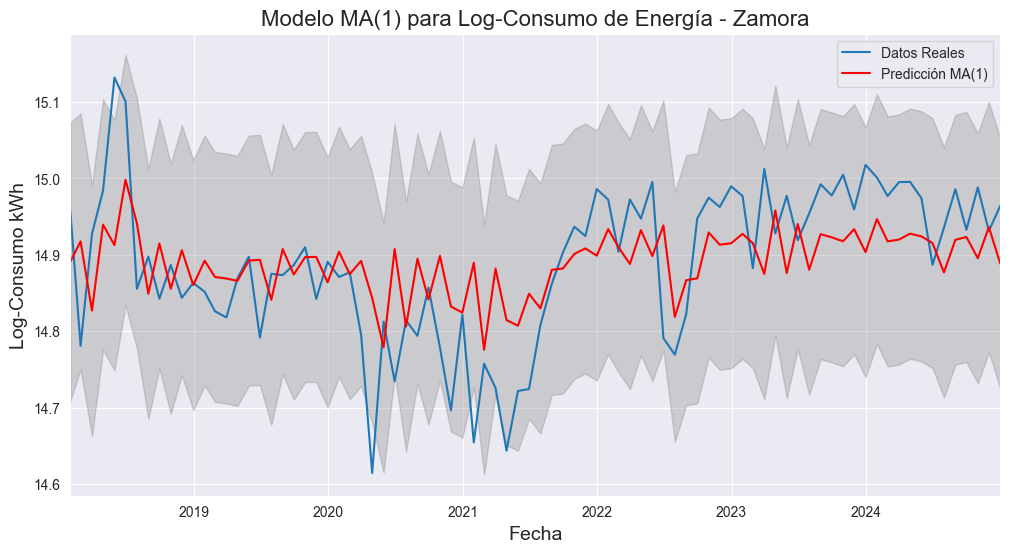

In [67]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_lineaA.index, y=df_lineaA["Zamora"], label="Datos Reales")
sns.lineplot(x=df_lineaA.index, y=yhat_zamora_ma1, color='red', label="Predicción MA(1)")
plt.fill_between(df_lineaA.index, yhat_zamora_ma1_conf_int.iloc[:,0], yhat_zamora_ma1_conf_int.iloc[:,1], color='gray', alpha=0.3, label="Intervalo de Confianza 95%")
plt.xlim(df_lineaA.index[0], df_lineaA.index[-1])
plt.ylabel("Log-Consumo kWh", fontsize=14)
plt.xlabel("Fecha", fontsize=14)
plt.title("Modelo MA(1) para Log-Consumo de Energía - Zamora", fontsize=16)
plt.show()

In [68]:
# Métricas de evaluación
mape_ma1 = mean_absolute_percentage_error(df_lineaA["Zamora"], yhat_zamora_ma1)*100
print(f"MSE AR(1): {results_zamora_ma1.mse:.3f}")
print(f"MAPE AR(1): {mape_ma1:.3f}%")
print(f"MAE AR(1): {results_zamora_ma1.mae:.3f}")

MSE AR(1): 0.007
MAPE AR(1): 0.441%
MAE AR(1): 0.066


# Modelación San Diego

In [69]:
model_sandiego_ar1=ARIMA(df_lineaA["San Diego"], order=(1,0,0)) # p, d, q
results_sandiego_ar1=model_sandiego_ar1.fit()
results_sandiego_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              San Diego   No. Observations:                   84
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  64.507
Date:                Wed, 03 Dec 2025   AIC                           -123.013
Time:                        22:23:19   BIC                           -115.721
Sample:                    01-31-2018   HQIC                          -120.082
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5643      0.042    344.762      0.000      14.481      14.647
ar.L1          0.6675      0.051     13.134      0.000       0.568       0.767
sigma2         0.0125      0.001      9.740      0.000       0.010       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                40.56
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

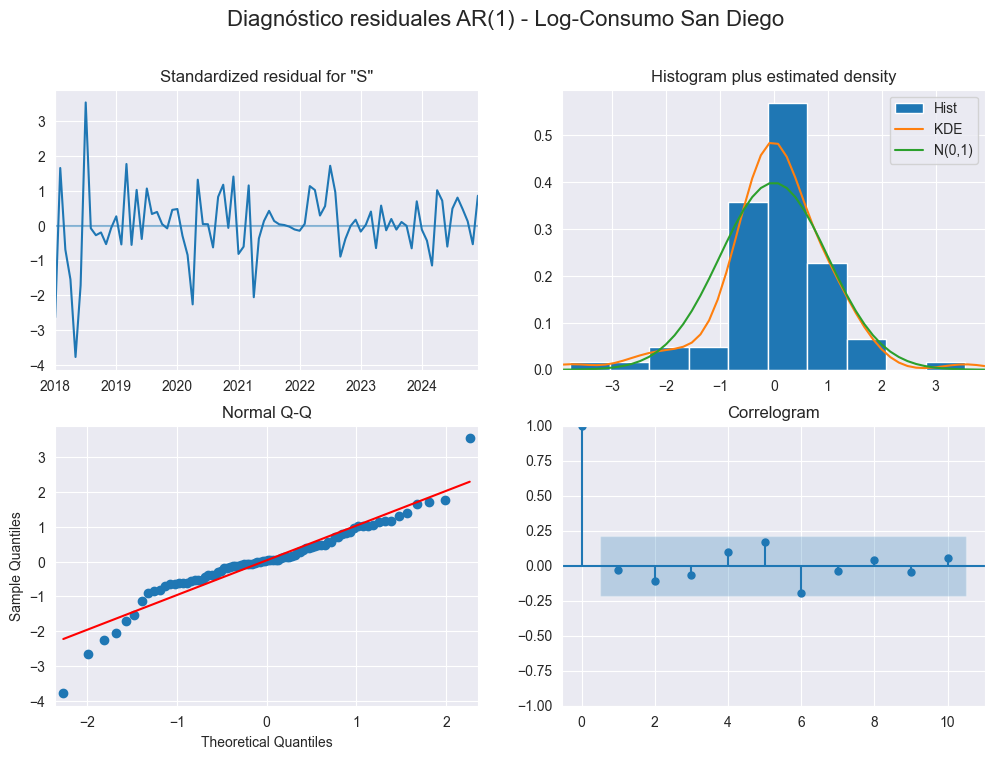

In [70]:
results_sandiego_ar1.plot_diagnostics(figsize=(12,8))
plt.suptitle("Diagnóstico residuales AR(1) - Log-Consumo San Diego", fontsize=16)
plt.show()

Se cumplen todos los supuestos de los residuos

In [71]:
predicciones_sandiego = results_sandiego_ar1.get_prediction(start=0, end=len(df_lineaA)-1)
yhat_sandiego_ar1 = predicciones_sandiego.predicted_mean
yhat_sandiego_ar1_conf_int = predicciones_sandiego.conf_int(alpha=0.05)

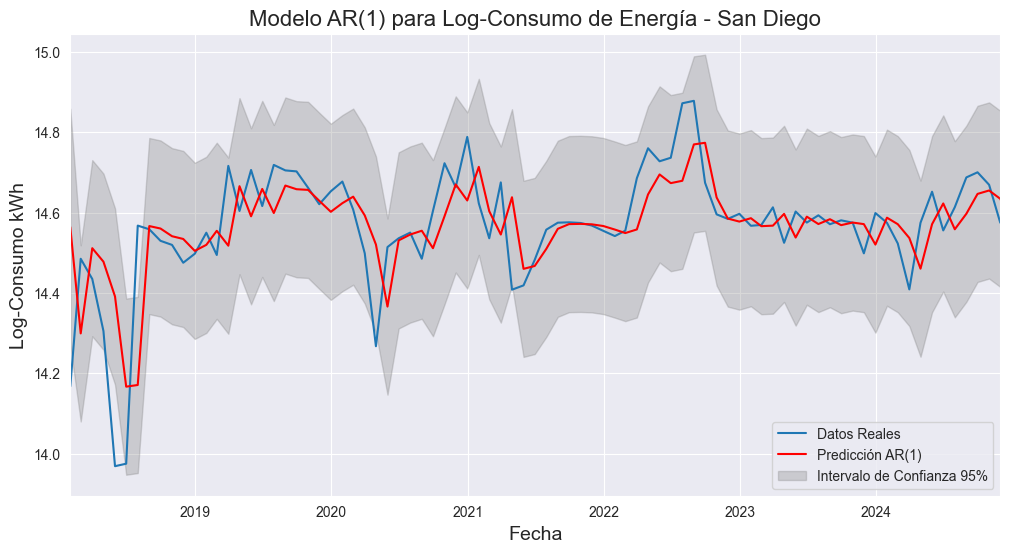

In [72]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_lineaA.index, y=df_lineaA["San Diego"], label="Datos Reales")
sns.lineplot(x=df_lineaA.index, y=yhat_sandiego_ar1, color='red', label="Predicción AR(1)")
plt.fill_between(df_lineaA.index, yhat_sandiego_ar1_conf_int.iloc[:,0], yhat_sandiego_ar1_conf_int.iloc[:,1], color='gray', alpha=0.3, label="Intervalo de Confianza 95%")
plt.xlim(df_lineaA.index[0], df_lineaA.index[-2])
plt.legend()
plt.ylabel("Log-Consumo kWh", fontsize=14)
plt.xlabel("Fecha", fontsize=14)
plt.title("Modelo AR(1) para Log-Consumo de Energía - San Diego", fontsize=16)
plt.show()

In [73]:
# Métricas de evaluación
mape_ar1 = mean_absolute_percentage_error(df_lineaA["San Diego"], yhat_sandiego_ar1)*100
print(f"MSE AR(1): {results_sandiego_ar1.mse:.3f}")
print(f"MAPE AR(1): {mape_ar1:.3f}%")
print(f"MAE AR(1): {results_sandiego_ar1.mae:.3f}")

MSE AR(1): 0.013
MAPE AR(1): 0.535%
MAE AR(1): 0.078


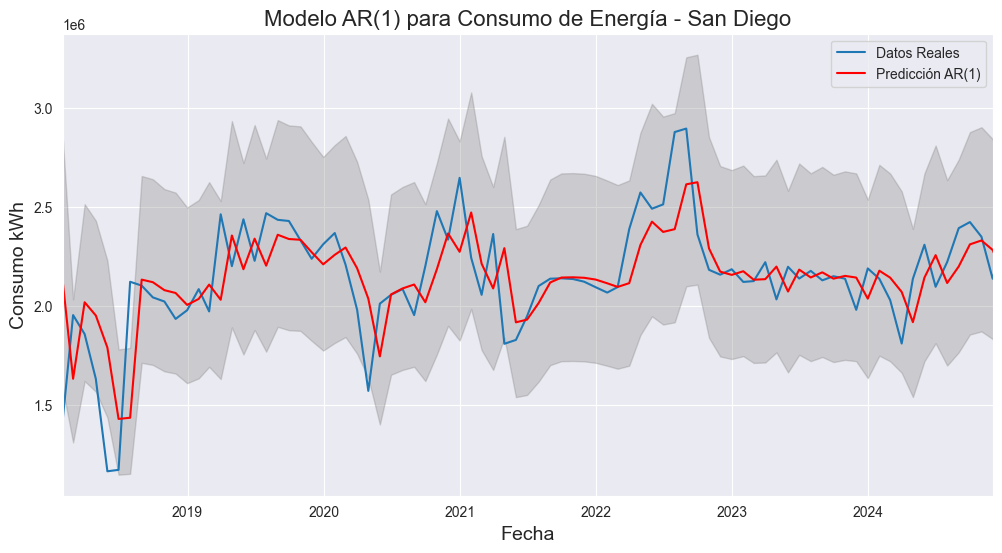

In [74]:
sigma2 = results_sandiego_ar1.params[2]   # varianza del error
pred_levels_unbiased = np.exp(yhat_sandiego_ar1 + 0.5 * sigma2)  # ajuste sesgo
levels_sandiego_ar1_conf_inf = np.exp(yhat_sandiego_ar1_conf_int.iloc[:,0] + 0.5 * sigma2)
levels_sandiego_ar1_conf_sup = np.exp(yhat_sandiego_ar1_conf_int.iloc[:,1] + 0.5 * sigma2)

plt.figure(figsize=(12,6))
sns.lineplot(x=df_lineaA.index, y=np.exp(df_lineaA["San Diego"]), label="Datos Reales")
sns.lineplot(x=df_lineaA.index, y=pred_levels_unbiased, color='red', label="Predicción AR(1)")
plt.fill_between(df_lineaA.index, levels_sandiego_ar1_conf_inf, levels_sandiego_ar1_conf_sup, color='gray', alpha=0.3, label="Intervalo de Confianza 95%")
plt.xlim(df_lineaA.index[0], df_lineaA.index[-2])
plt.ylabel("Consumo kWh", fontsize=14)
plt.xlabel("Fecha", fontsize=14)
plt.title("Modelo AR(1) para Consumo de Energía - San Diego", fontsize=16)
plt.show()

# Modelación Envigado

In [77]:
model_envigado=ARIMA(df_lineaA["Envigado"], order=(1,1,0)) # p, d, q
results_envigado=model_envigado.fit()
results_envigado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Envigado   No. Observations:                   84
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  94.801
Date:                Wed, 03 Dec 2025   AIC                           -185.601
Time:                        22:27:01   BIC                           -180.764
Sample:                    01-31-2018   HQIC                          -183.658
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3731      0.072     -5.175      0.000      -0.514      -0.232
sigma2         0.0060      0.001      9.001      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                21.37
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
results = het_arch(results_envigado.resid**2, ddof=1+1)
print(f"-------ARCH test H0: homocedasticidad-------")
print(f"Estadístico lm: {results[0]:.6f}")
print(f"lm p-value: {results[1]:.6f}")
print(f"Estadístico F: {results[2]:.6f}")
print(f"F p-value: {results[3]:.6f}")

-------ARCH test H0: homocedasticidad-------
Estadístico lm: 8.721941
lm p-value: 0.558680
Estadístico F: 0.868361
F p-value: 0.566743


In [79]:
print("-----Anderson-Darling test-----")
print(anderson(results_envigado.resid, dist='norm'))
print("\n-----Shapiro-Wilk test-----")
print(shapiro(results_envigado.resid))

-----Anderson-Darling test-----
AndersonResult(statistic=28.861638856519264, critical_values=array([0.552, 0.628, 0.754, 0.879, 1.046]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.17243149079768577, scale=1.611621726368019)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

-----Shapiro-Wilk test-----
ShapiroResult(statistic=0.11342416254617382, pvalue=3.939225154162296e-20)


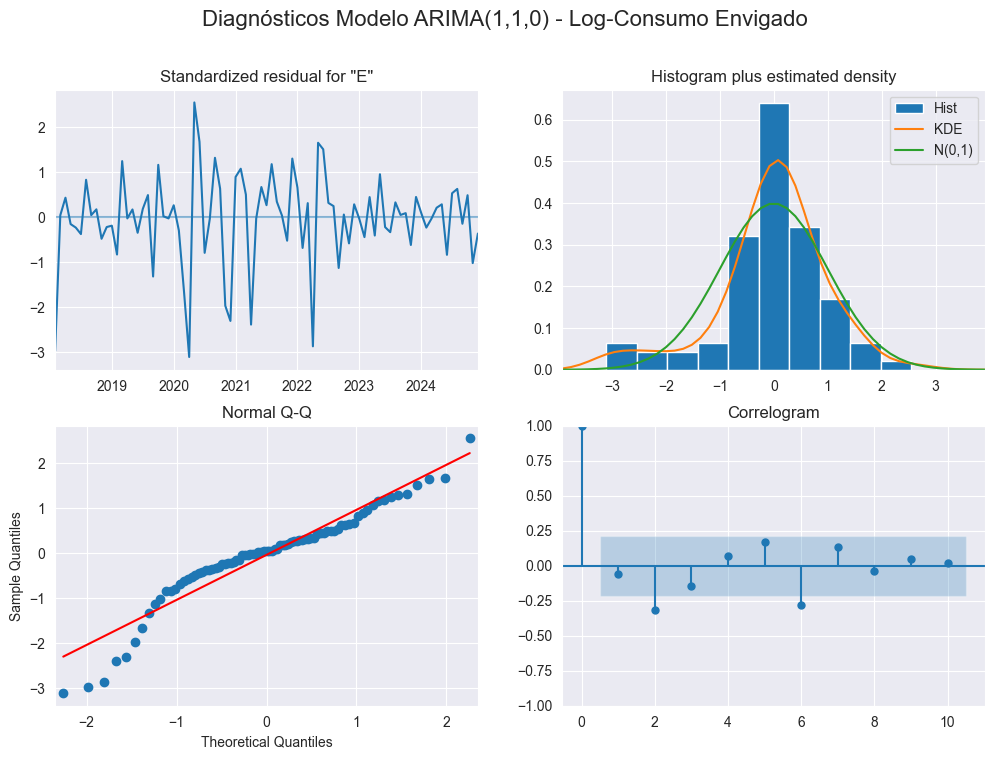

In [80]:
results_envigado.plot_diagnostics(figsize=(12,8))
plt.suptitle("Diagnósticos Modelo ARIMA(1,1,0) - Log-Consumo Envigado", fontsize=16)
plt.show()

Se cumplen todos los supuestos de los residuos

In [81]:
predicciones_envigado = results_envigado.get_prediction(start=1, end=len(df_lineaA)-1) # start = 1 cuando es arima(p,1,q)
yhat_envigado = predicciones_envigado.predicted_mean
yhat_envigado_conf_int = predicciones_envigado.conf_int(alpha=0.05)

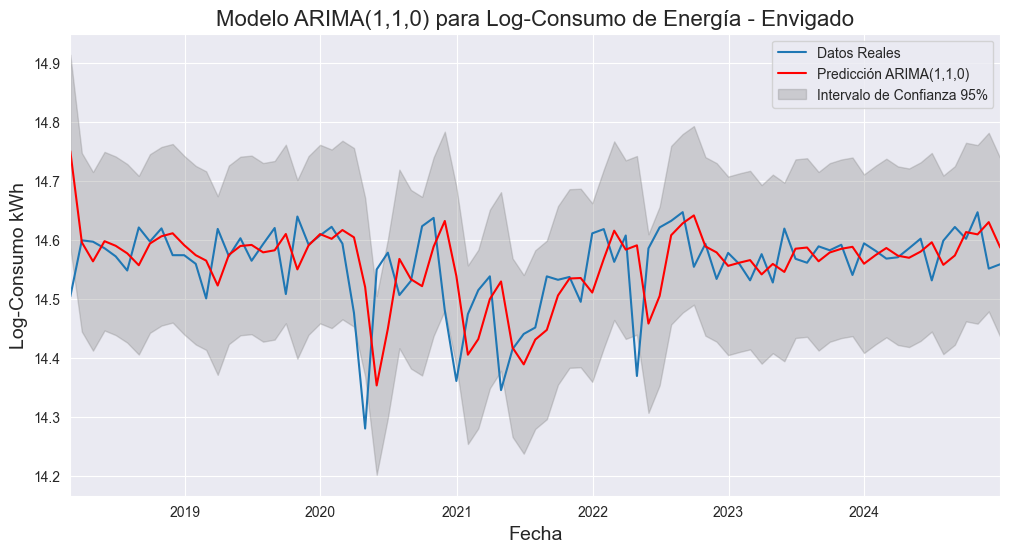

In [82]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_lineaA.index[1:], y=df_lineaA["Envigado"][1:], label="Datos Reales")
sns.lineplot(x=df_lineaA.index[1:], y=yhat_envigado, color='red', label="Predicción ARIMA(1,1,0)")
plt.fill_between(df_lineaA.index[1:], yhat_envigado_conf_int.iloc[:,0], yhat_envigado_conf_int.iloc[:,1], color='gray', alpha=0.3, label="Intervalo de Confianza 95%")
plt.xlim(df_lineaA.index[1], df_lineaA.index[-1])
plt.legend()
plt.ylabel("Log-Consumo kWh", fontsize=14)
plt.xlabel("Fecha", fontsize=14)
plt.title("Modelo ARIMA(1,1,0) para Log-Consumo de Energía - Envigado", fontsize=16)
plt.show()

In [83]:
# Métricas de evaluación
mape_envigado = mean_absolute_percentage_error(df_lineaA["Envigado"][1:], yhat_envigado)*100
print(f"MSE: {results_envigado.mse:.3f}")
print(f"MAPE: {mape_envigado:.3f}%")
print(f"MAE: {results_envigado.mae:.3f}")

MSE: 2.596
MAPE: 0.368%
MAE: 0.228
